In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Load the weather data and merge them into our two DataFrames.'''
path = r'D:\Springboard_DataSci\Assignments\Capstone_2--Airport_weather\data'
os.chdir(path)
print('Loading weather events')
weather_events = pd.read_csv('weather_events.csv')
print('Loading flight data')
departing_flights = pd.read_csv('departing_flights.csv')
arriving_flights = pd.read_csv('arriving_flights.csv')

Loading weather events
Loading flight data


In [3]:
# Merge the DataFrames.
departure_events = departing_flights.merge(
    weather_events, how='left', left_on=['ORIGIN','DepartureDate'],
    right_on=['Airport','Date'], validate='one_to_many')
arrival_events = arriving_flights.merge(
    weather_events, how='left', left_on=['DEST','ArrivalDate'],
    right_on=['Airport','Date'], validate='one_to_many')

In [4]:
# Drop redundant columns.
departure_events.drop(['Airport','Date'], axis=1, inplace=True)
arrival_events.drop(['Airport','Date'], axis=1, inplace=True)

# Clean up the column names.
inputVars = pd.Series(['Cold','Fog','Hail','Rain','Snow','Storm'], name='Code')
column_renames = {'ARR_DEL15':'ArrivDel',
                  'DEP_DEL15':'DepartDel',
                  'ColdCode':'Cold',
                  'FogCode':'Fog',
                  'HailCode':'Hail',
                  'RainCode':'Rain',
                  'SnowCode':'Snow',
                  'StormCode':'Storm'}
departure_events.rename(columns=column_renames, inplace=True)
arrival_events.rename(columns=column_renames, inplace=True)

# NaN's mean no weather events on that day. Fill them in with 0's.
for column in inputVars:
    departure_events[column].fillna(0, inplace=True)
    arrival_events[column].fillna(0, inplace=True)

In [5]:
# Save the results.
# departure_events.to_csv('departure_events.csv') #Uncomment to save.
# arrival_events.to_csv('arrival_events.csv')

In [6]:
'''Exploratory data analysis'''
FRAC_CANCELLED = 'FracCancelled'
FRAC_DELAYED = 'FracDelayed'
departure_events[FRAC_CANCELLED] = departure_events.WeatherCancelled/departure_events.Flights
arrival_events[FRAC_CANCELLED] = arrival_events.WeatherCancelled/arrival_events.Flights
departure_events[FRAC_DELAYED] = departure_events.WeatherDelayed/departure_events.Flights
arrival_events[FRAC_DELAYED] = arrival_events.WeatherDelayed/arrival_events.Flights

X_dep = departure_events.loc[:, inputVars]
X_arr = arrival_events.loc[:, inputVars]

In [7]:
#Get the correlation matrix of data with X's features as columns.
def corrMatrixAndMax(df, labels=inputVars):
    corr = df.corr()
    n = corr.shape[0]
    max_corr_ID = np.argmax(np.abs(corr) - np.eye(n))
    return corr, np.unravel_index(max_corr_ID, [n,n])

#Get the value, and row and column labels of a particular df coordinate. Rounding is arbitrary.
def getCorrNameCoords(df, coordinates):
    row = coordinates[0]; col = coordinates[1]
    return round(df.iloc[row, col], 3), df.index[row], df.index[col]
        
#Max absolute difference.
maxAbsDiff = lambda A, B, axis=None: np.max(np.abs(A-B), axis=axis)

In [8]:
print('Deviation from X_dep and array of ints:', maxAbsDiff(X_dep, X_dep.astype(int)) )
print('Deviation from X_arr and array of ints:', maxAbsDiff(X_arr, X_arr.astype(int)) )
X_dep = X_dep.astype(int)
X_arr = X_arr.astype(int)

print('Calculating correlation matrices')
Corr_X_dep, coords_max_Corr_X_dep = corrMatrixAndMax(X_dep)
Corr_X_arr, coords_max_Corr_X_arr = corrMatrixAndMax(X_arr)
print('Max abs difference between Corr_X_dep and Corr_X_arr:', maxAbsDiff(Corr_X_dep, Corr_X_arr))
#Nearly identical, which makes sense given that they're from the same dates and airports.

Deviation from X_dep and array of ints: Cold     0.0
Fog      0.0
Hail     0.0
Rain     0.0
Snow     0.0
Storm    0.0
dtype: float64
Deviation from X_arr and array of ints: Cold     0.0
Fog      0.0
Hail     0.0
Rain     0.0
Snow     0.0
Storm    0.0
dtype: float64
Calculating correlation matrices
Max abs difference between Corr_X_dep and Corr_X_arr: Cold     0.000073
Fog      0.000518
Hail     0.000061
Rain     0.000518
Snow     0.000291
Storm    0.000089
dtype: float64


In [9]:
EV_CORR_MTRX = ' event correlation matrix:\n'
CORR_NAME_COORDS = 'Greatest correlation and name and coordinates:'
print('\nDeparture' + EV_CORR_MTRX + str(Corr_X_dep))
print(CORR_NAME_COORDS, getCorrNameCoords(Corr_X_dep, coords_max_Corr_X_dep))
print('\nArrival' + EV_CORR_MTRX + str(Corr_X_arr))
print(CORR_NAME_COORDS, getCorrNameCoords(Corr_X_arr, coords_max_Corr_X_arr))


Departure event correlation matrix:
           Cold       Fog      Hail      Rain      Snow     Storm
Cold   1.000000  0.018395 -0.002790  0.008945  0.051714  0.039776
Fog    0.018395  1.000000  0.013986  0.111922  0.142345  0.012662
Hail  -0.002790  0.013986  1.000000  0.082527  0.218473 -0.005358
Rain   0.008945  0.111922  0.082527  1.000000  0.015431  0.109573
Snow   0.051714  0.142345  0.218473  0.015431  1.000000  0.034764
Storm  0.039776  0.012662 -0.005358  0.109573  0.034764  1.000000
Greatest correlation and name and coordinates: (0.218, 'Hail', 'Snow')

Arrival event correlation matrix:
           Cold       Fog      Hail      Rain      Snow     Storm
Cold   1.000000  0.018435 -0.002783  0.009018  0.051733  0.039786
Fog    0.018435  1.000000  0.014042  0.112439  0.142481  0.012742
Hail  -0.002783  0.014042  1.000000  0.082587  0.218492 -0.005343
Rain   0.009018  0.112439  0.082587  1.000000  0.015722  0.109662
Snow   0.051733  0.142481  0.218492  0.015722  1.000000  0.034803

This is suspicious. Hail is a warm-weather event; snow is a cold-weather event. 
Let's look at the Hail and Cold codes to see how much overlap there is.

In [10]:
def SumByPair(df, label1, label2):
    return df.groupby([label1, label2]).size().reset_index().rename(columns={0:'count'})
print('\nDepartures:\n' + str(SumByPair(X_dep, 'Hail', 'Cold')))
print('\nArrivals:\n' + str(SumByPair(X_arr, 'Hail', 'Cold')))


Departures:
   Hail  Cold  count
0     0     0   5806
1     0     1     12
2     1     0     22

Arrivals:
   Hail  Cold  count
0     0     0   5822
1     0     1     12
2     1     0     22


There are no coexisting Hail-1 and Cold-1 codes, which is what we want. The coexisting
0 codes for both seem to be driving up this correlation, which is acceptable.

The correlations between all the weather variables seem fairly low, but both correlation
matrices include all the rows of 0, where there are no weather events. We should reevaluate
based on the rows that are not all zero.

In [11]:
nonzero_X_dep = X_dep[(X_dep.T != 0).any()]
nonzero_X_arr = X_arr[(X_arr.T != 0).any()]
nonzero_Corr_X_dep, nonzero_coords_max_Corr_X_dep = corrMatrixAndMax(nonzero_X_dep)
nonzero_Corr_X_arr, nonzero_coords_max_Corr_X_arr = corrMatrixAndMax(nonzero_X_arr)
print('Max abs difference between nonzero_Corr_X_dep and nonzero_Corr_X_arr:',
      maxAbsDiff(nonzero_Corr_X_dep, nonzero_Corr_X_arr))
#Identical correlation matrices, so we don't have to separate arrival/departure here.

print('\nNonzero' + EV_CORR_MTRX, nonzero_Corr_X_dep)
print(CORR_NAME_COORDS, getCorrNameCoords(nonzero_Corr_X_dep, nonzero_coords_max_Corr_X_dep))

Max abs difference between nonzero_Corr_X_dep and nonzero_Corr_X_arr: Cold     0.0
Fog      0.0
Hail     0.0
Rain     0.0
Snow     0.0
Storm    0.0
dtype: float64

Nonzero event correlation matrix:
            Cold       Fog      Hail      Rain      Snow     Storm
Cold   1.000000 -0.003295 -0.006605 -0.043824  0.041899  0.034635
Fog   -0.003295  1.000000 -0.016468 -0.296658  0.067089 -0.031260
Hail  -0.006605 -0.016468  1.000000  0.044240  0.208793 -0.012730
Rain  -0.043824 -0.296658  0.044240  1.000000 -0.200257  0.051980
Snow   0.041899  0.067089  0.208793 -0.200257  1.000000  0.014505
Storm  0.034635 -0.031260 -0.012730  0.051980  0.014505  1.000000
Greatest correlation and name and coordinates: (-0.297, 'Fog', 'Rain')


Now the greatest correlation is between rain and fog, at about -0.297. Paradoxically,
this correlation was positive with all zero rows included! Perhaps we have the same
effect here as with hail and cold. Let's find out.

In [12]:
print('\nDepartures:\n' + str(SumByPair(X_dep, 'Rain', 'Fog')))
print('\nDepartures (fog first):\n' + str(SumByPair(X_dep, 'Fog', 'Rain')))


Departures:
    Rain  Fog  count
0      0    0   3459
1      0    1    158
2      0    2    201
3      1    0   1111
4      1    1     56
5      1    2    144
6      2    0    403
7      2    1     15
8      2    2     62
9      3    0    185
10     3    1     12
11     3    2     34

Departures (fog first):
    Fog  Rain  count
0     0     0   3459
1     0     1   1111
2     0     2    403
3     0     3    185
4     1     0    158
5     1     1     56
6     1     2     15
7     1     3     12
8     2     0    201
9     2     1    144
10    2     2     62
11    2     3     34


In [13]:
print('\nNonzero rows:\n' + str(SumByPair(nonzero_X_dep, 'Rain', 'Fog')))
print('\nNonzero rows (fog first):\n' + str(SumByPair(nonzero_X_dep, 'Fog', 'Rain')))


Nonzero rows:
    Rain  Fog  count
0      0    0     96
1      0    1    158
2      0    2    201
3      1    0   1111
4      1    1     56
5      1    2    144
6      2    0    403
7      2    1     15
8      2    2     62
9      3    0    185
10     3    1     12
11     3    2     34

Nonzero rows (fog first):
    Fog  Rain  count
0     0     0     96
1     0     1   1111
2     0     2    403
3     0     3    185
4     1     0    158
5     1     1     56
6     1     2     15
7     1     3     12
8     2     0    201
9     2     1    144
10    2     2     62
11    2     3     34


Nearly all the 0-0 rows got cut. All other rows are preserved. The negative correlation after
the cut shows that an overlap between rain and fog is uncommon. Intuitively this makes sense, as
fog is generally a fair-weather event and rain is generally a poor-weather event. Incidentally,
note that light rain is more likely when the fog is heavy.

Because the untrimmed departure and arrival correlation matrices are nearly identical,
we will just use the departure events now. Let's see what the average values per
column are, weighted by flight.

In [14]:
Avg = pd.DataFrame(map(list, zip(inputVars.values, np.average(
    X_dep, axis=0, weights=departure_events.Flights))), columns=['Code', 'WtAvg'])
Avg = Avg.set_index('Code')['WtAvg']
print('\nWeighted averages: ' + str(Avg) + '\n')


Weighted averages: Code
Cold     0.002057
Fog      0.194690
Hail     0.003433
Rain     0.497611
Snow     0.057978
Storm    0.008619
Name: WtAvg, dtype: float64



Now let's do some plots, per code, categorized by code value. To make things
simpler we will not weight these values for now.

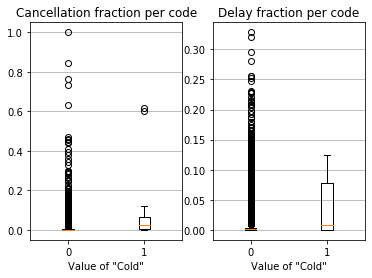

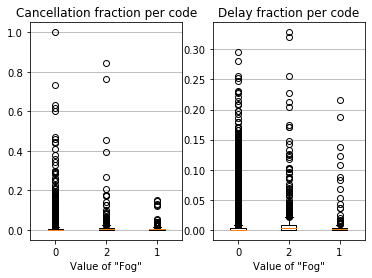

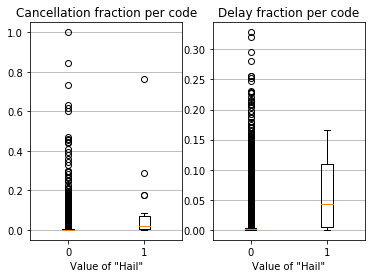

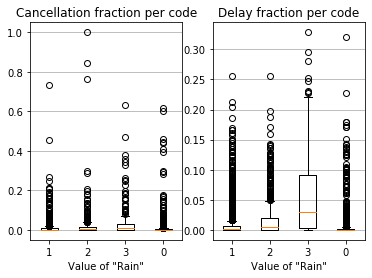

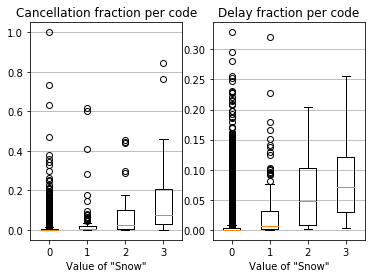

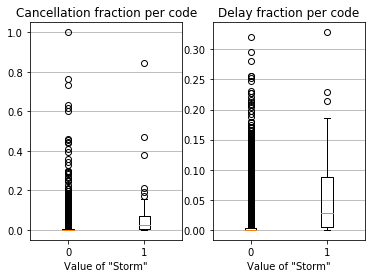

In [15]:
frac_cancelled = departure_events['FracCancelled'].to_numpy()
frac_delayed = departure_events['FracDelayed'].to_numpy()

for weatherCode in inputVars:
    unique_codes = X_dep[weatherCode].unique() #makes a Series of value counts indexed by code #
    cancelled_per_code = [frac_cancelled[X_dep[weatherCode]==j] for j in unique_codes]
    delayed_per_code = [frac_delayed[X_dep[weatherCode]==j] for j in unique_codes]
    
    fig, axs = plt.subplots(1,2)
    axs[0].boxplot(cancelled_per_code)
    axs[0].set_title('Cancellation fraction per code')
    axs[1].boxplot(delayed_per_code)
    axs[1].set_title('Delay fraction per code')
    for j in [0,1]:
        axs[j].set_xticklabels(unique_codes)
        axs[j].set_xlabel('Value of "' + weatherCode + '"')
        axs[j].yaxis.grid(True)
    plt.show()

The medians of some of these features clearly are affected by the feature value;
however, none of them seem to add up to much more than about 0.20, meaning that
we should not expect that these weather events will have an overwhelming affect
on delays and cancellations. Still, there do seem to be trends that emerge.